In [ ]:
!pip install pyswarms

2021-02-12 09:28:27,636 - pyswarms.single.global_best - INFO - Optimize for 600 iters with {'c1': 1.7, 'c2': 1.7, 'w': 0.5}
pyswarms.single.global_best: 100%|██████████|600/600, best_cost=-.389
2021-02-12 09:28:29,069 - pyswarms.single.global_best - INFO - Optimization finished | best cost: -0.3887630364774501, best pos: [2.74727929 5.48732351]


O valor máximo de cb2 é: 0.3887630364774501 mol/L
t1: 2.74727928868398 s
t2: 5.487323505186778 s


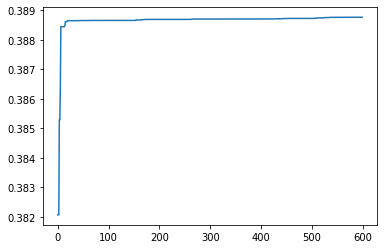

In [ ]:
"""
Otimização sistema isotérmico de reatores CSTR em série 
com reação complexa (A --> B --> C), usando PSO.
"""
import math as m
import matplotlib.pyplot as plt
import numpy as np
import pyswarms as ps
from pyswarms.utils.plotters import plot_cost_history


# Modelo do sistema
def cstr_serie(t1, t2):
    """
    Modelo dos reatores CSTR em série, em função dos tempos de residência (t1 e t2) 
    dos reatores. Retorna o valor da concentração de B no segundo reator (cb2 [mol/L]).

                        k1    k3
    Reação 1º Reator: A --> B --> C

                        k2    k4
    Reação 2º Reator: A --> B --> C

    (Tempo de residência (t) = Volume/Vazão Volumétrica)

    Referências:
    MANOUSIOUTHAKIS, V. e SOURLAS, D. A GLOBAL OPTIMIZATION APPROACH TO RATIONALLY
    CONSTRAINED RATIONAL PROGRAMMING. Chemical Engineering Communication. 1992. DOI:
    http://dx.doi.org/10.1080/00986449208936033.

    RYOO, H.S. e SAHINIDIS, N.V. GLOBAL OPTIMIZATION OF NONCONVEX NLPs AND
    MINLPs WITH APPLICATIONS IN PROCESS DESIGN. Computers Chemical Enginnering. 1995. DOI:
    https://doi.org/10.1016/0098-1354(94)00097-2. 
    """
    # Constants cinéticas da reação nos dois reatores
    k1 = 0.09755988  # s^-1
    k2 = 0.99 * k1   # s^-1
    k3 = 0.0391908   # s^-1
    k4 = 0.9 * k3    # s^-1

    # Restrição relacionada ao custo
    if t1 ** 0.5 + t2 ** 0.5 <= 4:
        # Balanço de massa para os dois componentes no sistema
        ca1 = 1 / (1 + k1 * t1)
        ca2 = ca1 / (1 + k2 * t2)
        cb1 = (1 - ca1) / (1 + k3 * t1)
        cb2 = (cb1 + ca1 - ca2) / (1 + k4 * t2)

    else:
        # Caso os volumes não satisfaçam a equação o programa retorna 0,
        # Este resultado não será escolhido pelo PSO.
        cb2 = 0

    return cb2


def max_cb2(particles):
    """
    O modelo do otimizador recebe uma lista de partículas (possíveis soluções) e deve retornar
    uma lista com os valores resposta da variável maximizada ou minimizada.

    particles: lista de listas. Cada uma dessas listas é referente a uma partícula. O primeiro
               elemento é referente à primeira variável e assim por diante.
    """
    cb2_list = []
    for particle in particles:
        t1 = particle[0]
        t2 = particle[1]

        cb2 = cstr_serie(t1, t2)

        # Negativo, pois o algoritmo do PSO é configurado para minimização.
        cb2_list.append(-cb2)

    return cb2_list


def main_optimization(kwargs):
    """
    Estrutura principal da otimização. Criação do otimizator e execução do algoritmo. Retornar
    como resultado um dicionário contendo os valores ótimos de Cb2, t1 e t2.
    """
    # Número de iterações do PSO
    iter = 600
    optimizer = ps.single.GlobalBestPSO(**kwargs)  # Construção do otimizador

    cost, pos = optimizer.optimize(max_cb2, iter)

    cost_history = optimizer.cost_history
    cost_history = [(-1) * cb2 for cb2 in cost_history]

    print(f'O valor máximo de cb2 é: {-cost} mol/L')
    print(f't1: {pos[0]} s')
    print(f't2: {pos[1]} s')

    result = {
        'cb': -cost,
        't1': pos[0],
        't2': pos[1],
        'history': cost_history
    }
    return result


if __name__ == "__main__":
    # Restrições do problema (tempos de residência)
    lb = [1e-5, 1e-5]
    ub = [16, 16]
    bounds = (lb, ub)

    # Hiperparâmetros do PSO
    options = {"c1": 1.7, "c2": 1.7, "w": 0.5}

    # Dicionário de configurações gerais do PSO
    kwargs = {
        "n_particles": 25,
        "dimensions": 2,
        "options": options,
        "bounds": bounds
    }

    result = main_optimization(kwargs)

    plt.plot(result['history'])
    plt.show()